In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas_profiling
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline
%matplotlib inline

In [2]:
sns.set_style('whitegrid')
sns.set_color_codes('dark')

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
df = train_df.copy()

### Head

In [5]:
df.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


#### From the above we can clearly see that Loan_Id feature will not help us in anyway futher. So will drop this feature.

In [6]:
df = df.drop('Loan_ID', axis=1)

In [7]:
df.head(5)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [8]:
# report = df.profile_report()
# report.to_file('report.html')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


#### There are 5 features of number datatype and 7 features of string|object datatype
#### Also, there are missing values present in the dataset.
#### there is 44% of 0 present in Coapplicant feature

### Five Number Summary

In [10]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


#### ApplicantIncome, CoapplicantIncome and LoanAmount features are right skewed and Loan Amount Term and Credit History are left skewed, Hence the dataset is skewed dataset.
#### Outliers is present in ApplicantIncome, CoapplicantIncome, LoanAmount features.

## EDA

### Checking for missing values

In [11]:
def remove_missing_values(df):
    for i in df.columns:
        if df[i].isnull().sum() > 0:
            print("Removing missing values from feature -> {}".format(i))
            if df[i].dtype == 'object':
                df[i].fillna(value = df[i].mode()[0], inplace=True)
            else:
                df[i].fillna(value = df[i].median(), inplace=True)

In [12]:
missing_values = df.isnull().sum().sum()
if missing_values > 0:
    remove_missing_values(df)
else:
    print('There is no missing values present in the dataset')

Removing missing values from feature -> Gender
Removing missing values from feature -> Married
Removing missing values from feature -> Dependents
Removing missing values from feature -> Self_Employed
Removing missing values from feature -> LoanAmount
Removing missing values from feature -> Loan_Amount_Term
Removing missing values from feature -> Credit_History


### Checking for duplicate values

In [13]:
def remove_duplicate_values(df):
    for i in df.columns:
        if df[i].duplicated().sum() > 0:
            print("Removing duplicated values from feature -> {}".format(i))
            df[i].drop_duplicates()

In [14]:
duplicate_values = df.duplicated().sum()
if duplicate_values > 0:
    remove_duplicate_values(df)
else:
    print('There is no duplicate values present in the dataset')

There is no duplicate values present in the dataset


### Shape of dataset

In [15]:
df.shape

(614, 12)

### Checking percentage of 0 in dataset.

In [16]:
count = 0
for i in df.columns:
    if df[i].dtype != 'object':
        for j in df[i]:
            if j == 0.0:
                count += 1
            zero_percent = round((count / len(df)), 2)*100
        count = 0
        print("{} features has {}% zeroes".format(i, zero_percent)) if zero_percent != 0.0 else print('')


CoapplicantIncome features has 44.0% zeroes


Credit_History features has 14.000000000000002% zeroes


#### Therefore, CoapplicantIncome has 44% zeroes of dataset which state that Coapplicant has income 0 they can either house wifes, student or unemployed.
#### Credit_history has 14% zeroes of dataset which tell us that the applicant never took any loan and it is for the first time he/shie is taking loan.

### Univariate analysis

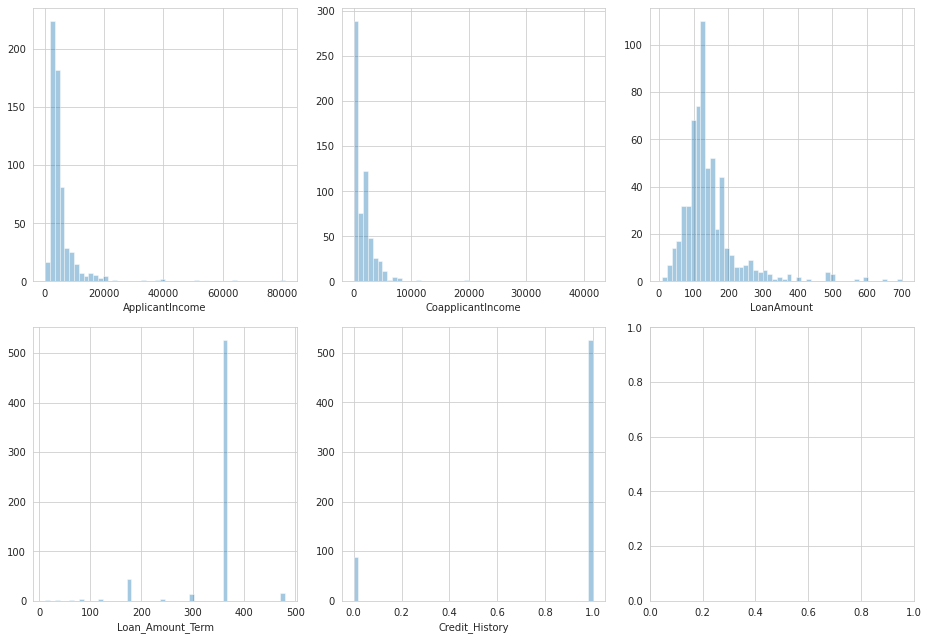

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(13,9));
row = col = 0
for i in df.columns:
    if df[i].dtype != 'object':
        if (row < 2) & (col < 3):
            sns.distplot(df[i], kde=False, bins=50, ax=axes[row][col]);
            col += 1
        else:
            row += 1
            col = 0
            sns.distplot(df[i], kde=False, bins=50, ax=axes[row][col]);
            col += 1
plt.tight_layout()

#### ApplicantIncome, CoapplicantIncome and LoanAmount feature looks normally distributed and right skewed.
#### Outliers is present in ApplicantIncome, LoanAmount and CoapplicantIncome features
#### Credit history feature shows us distribution of two categories that either people have taken loan in the past or not.
#### Loan Amount Term feature has higher magnitude around 370 due to which all other values are affected.

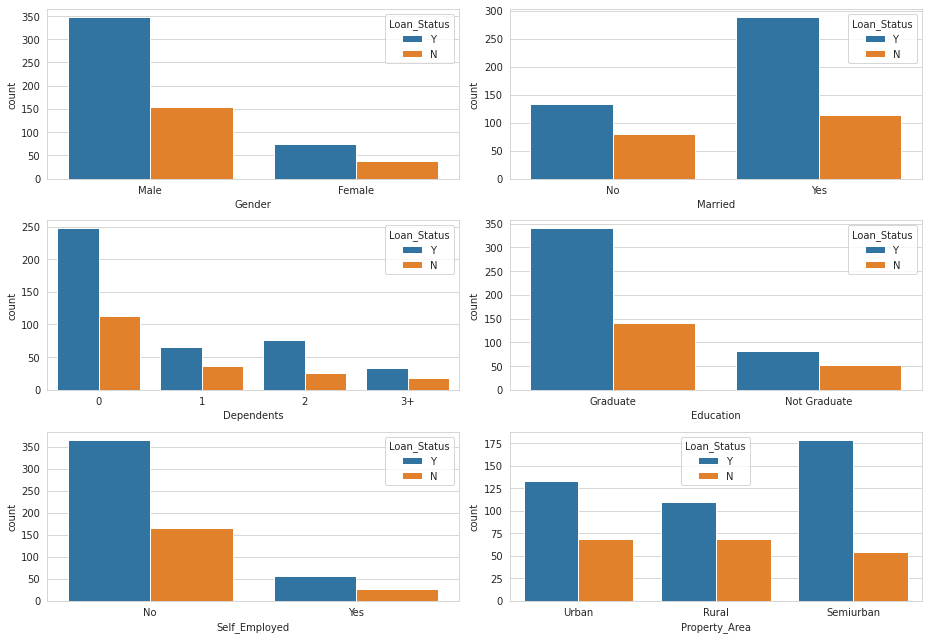

In [18]:
fig, axes = plt.subplots(3, 2, figsize=(13,9));
row = col = 0
for i in df.columns[:-1]:
    if df[i].dtype == 'object':
        if (row < 3) & (col < 2):
            sns.countplot(df[i], hue=df['Loan_Status'], ax=axes[row][col]);
            col += 1
        else:
            row += 1
            col = 0
            sns.countplot(df[i],hue=df['Loan_Status'], ax=axes[row][col]);
            col += 1
plt.tight_layout()

#### Male has high percentage to get the loan whereas female has less percentage.
#### People who are married has high possibilty to get loan status as Y in comparision to unmarried couples.
#### Those who have less dependents are getting yes loan status whereas the high dependents leads in difficulty of getting loan.
#### People who are educated easily getting loan approval.
#### Those who are not self employed that is working in a company getting loan approval easily in comparison to people who are running there business.
#### People with semi urban property area getting easily loan approval.

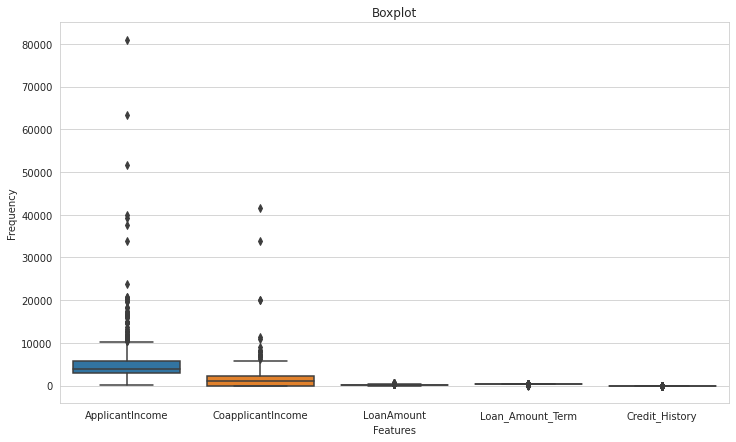

In [19]:
plt.figure(figsize=(12,7));
sns.boxplot(data=df);
plt.title('Boxplot');
plt.xlabel('Features');
plt.ylabel('Frequency');

#### Outliers is present in ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term and Credit History features. 
#### Also, we need to scale the data as applicant income feature has high magnitude which is affecting scalling of other features.

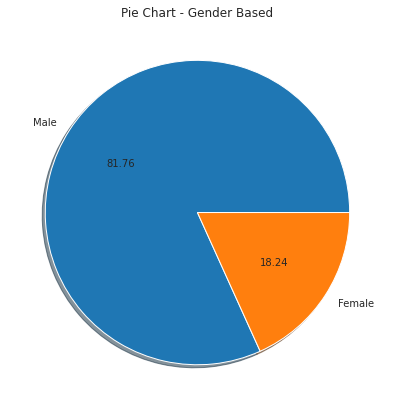

In [20]:
plt.figure(figsize=(12,7));
plt.pie(df['Gender'].value_counts(), labels=['Male', 'Female'], shadow=True, autopct='%0.2f');
plt.title('Pie Chart - Gender Based');

#### Above pie chart shows proportion of Male and Female groups based on the dataset.

### Bivariate Analysis

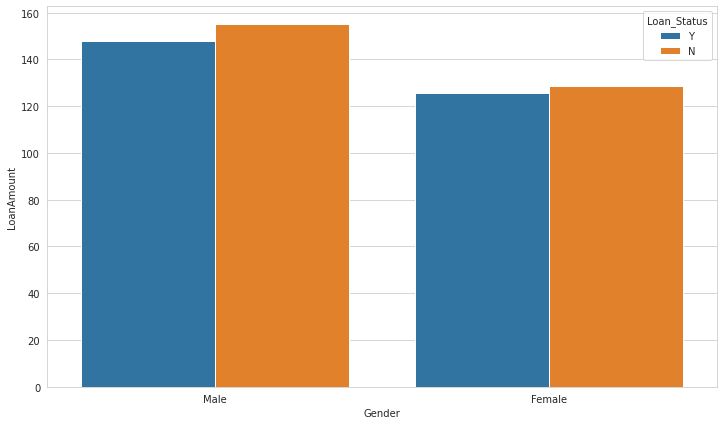

In [21]:
plt.figure(figsize=(12,7));
sns.barplot(x='Gender', y='LoanAmount', data=df, ci=False, hue='Loan_Status');

#### Above bar plot shows that average loan amount in males category is high with respect to females.
#### Both Male and Female have high loan rejected cases that means loan amount increases probability of loan will be cancelled also increases in both categories.

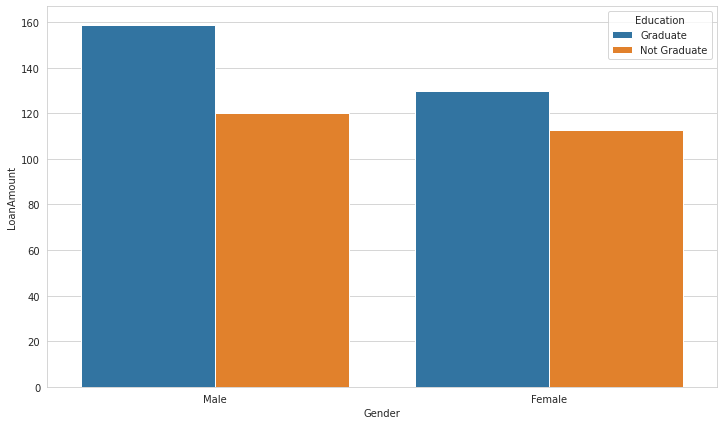

In [22]:
plt.figure(figsize=(12,7));
sns.barplot(x='Gender', y='LoanAmount', data=df, ci=False, hue='Education');

#### Graduated male applied for Loan more than female and have less probability of getting loan amount rejected than females.

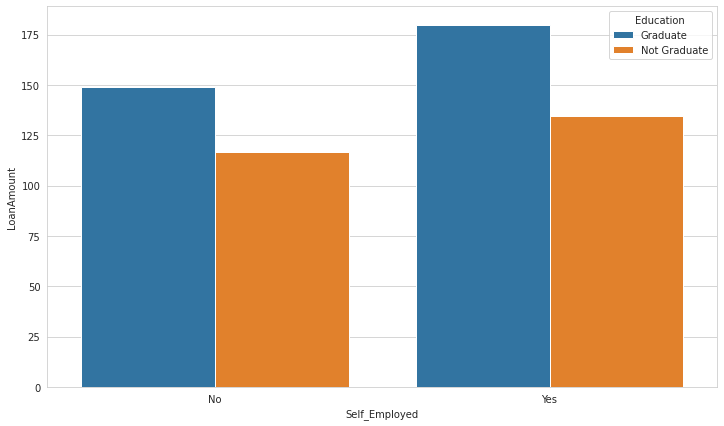

In [23]:
plt.figure(figsize=(12,7));
sns.barplot(x='Self_Employed', y='LoanAmount', data=df, ci=False, hue='Education');

#### Those who are graduated and self employed has high probability of loan approval in comparison to those who were not self employed and educated.

/home/pooja/.local/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/home/pooja/.local/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/home/pooja/.local/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


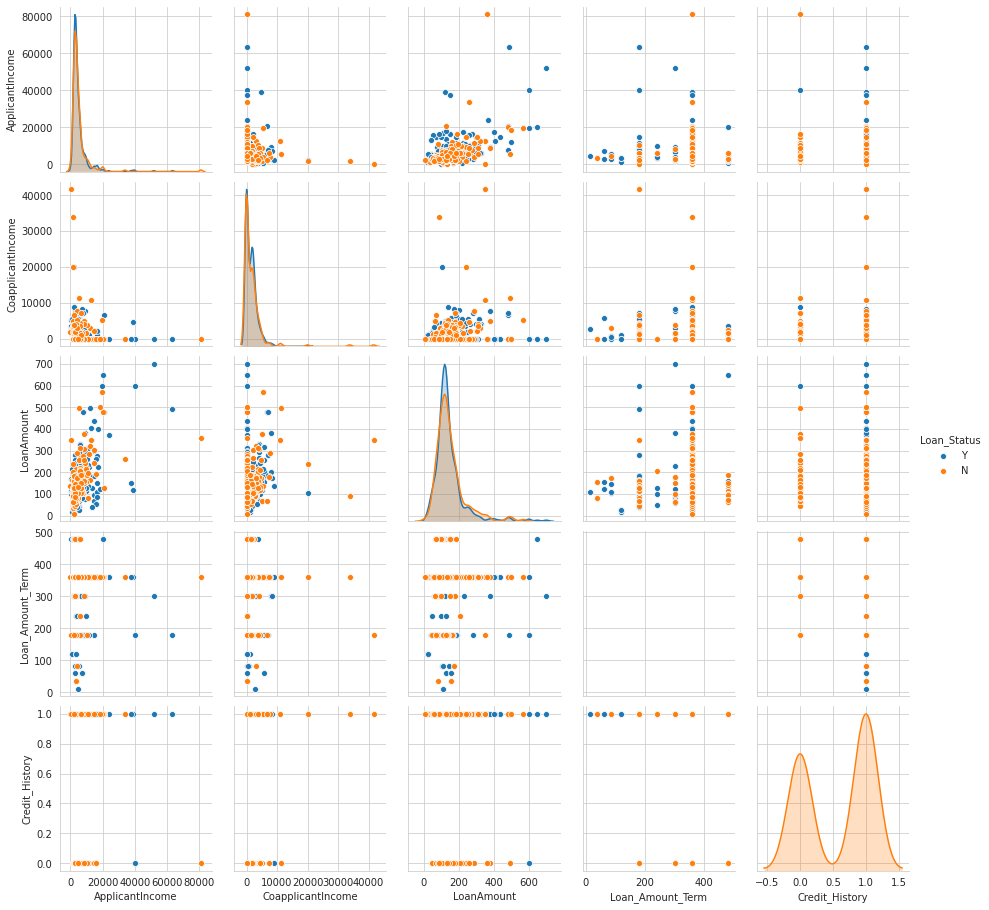

In [24]:
sns.pairplot(data=df, hue='Loan_Status');

#### Above pair plot shows that there is no feature that will have significant impact on loan status.
#### Applicant Income and Loan Amount shows little bit of relation.
#### Credit history density shows bi-modal behavior as there is only two categories 0 and 1 that is why it is showing two peaks.

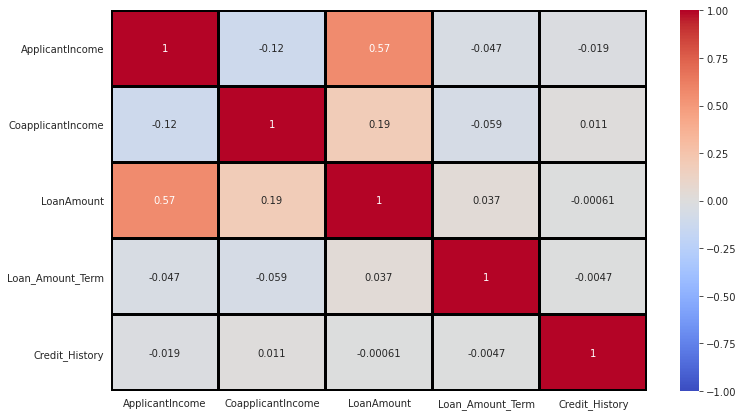

In [25]:
plt.figure(figsize=(12,7));
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm', linewidths=2, linecolor='black');

#### Above heat map shows that there is an relationship between loan amount and applicant income otherwise there is no significant relationship between features. 

/home/pooja/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


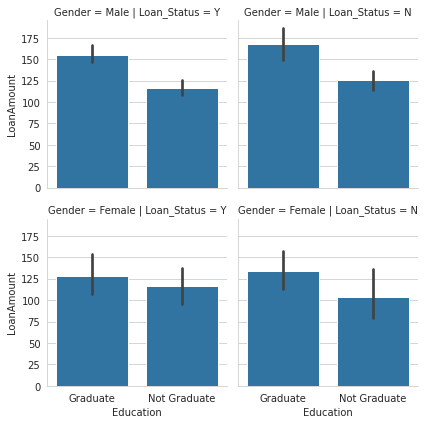

In [26]:
grid = sns.FacetGrid(data=df, row='Gender', col='Loan_Status');
grid.map(sns.barplot, 'Education', 'LoanAmount');

#### Above plot shows that graduated male has high percentage of rejected loan amount than non graduated male as the average loan amount is less.

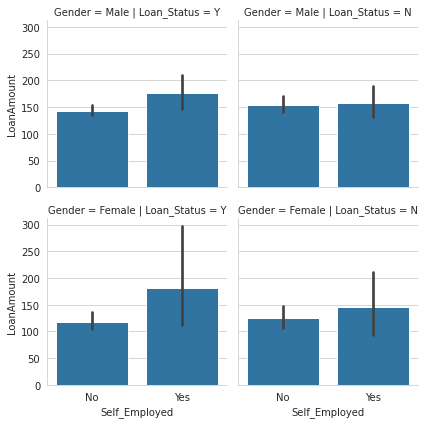

In [27]:
grid = sns.FacetGrid(data=df, row='Gender', col='Loan_Status');
grid.map(sns.barplot, 'Self_Employed', 'LoanAmount');

#### Male and Female who are self employed has high percentage of getting loan approval in comparison to male and female working somewhere else.

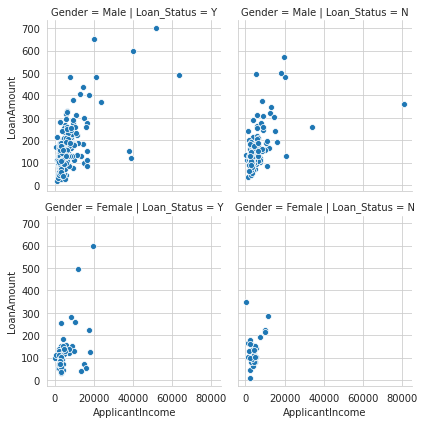

In [28]:
grid = sns.FacetGrid(data=df, row='Gender', col='Loan_Status');
grid.map(sns.scatterplot, 'ApplicantIncome', 'LoanAmount');

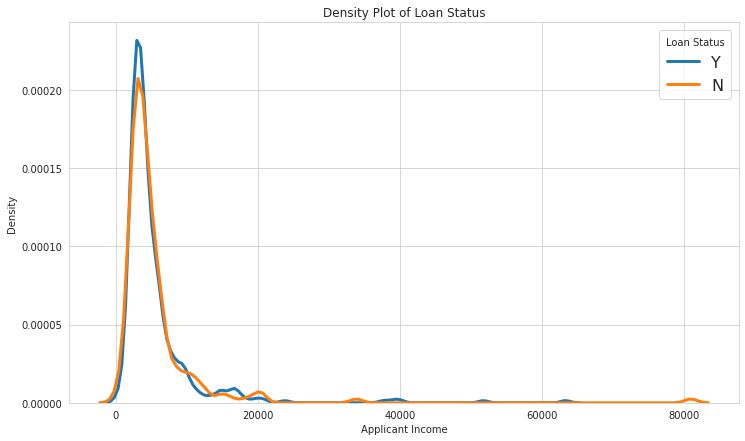

In [29]:
plt.figure(figsize=(12,7));
for i in df['Loan_Status'].unique():
    sub = df[df['Loan_Status'] == i]
    sns.distplot(sub['ApplicantIncome'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = i);
plt.legend(prop={'size': 16}, title = 'Loan Status');
plt.title('Density Plot of Loan Status');
plt.xlabel('Applicant Income');
plt.ylabel('Density');

#### Above plot states that applicant with income between range 10000 to 15000 have high chances of getting loan approval.

### Encode object variables into numericals

In [30]:
for i in df.columns:
    if df[i].dtype == 'object':
        df[i] = pd.Categorical(df[i]).codes

In [31]:
df.dtypes

Gender                  int8
Married                 int8
Dependents              int8
Education               int8
Self_Employed           int8
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area           int8
Loan_Status             int8
dtype: object

### Remove outliers from dataset

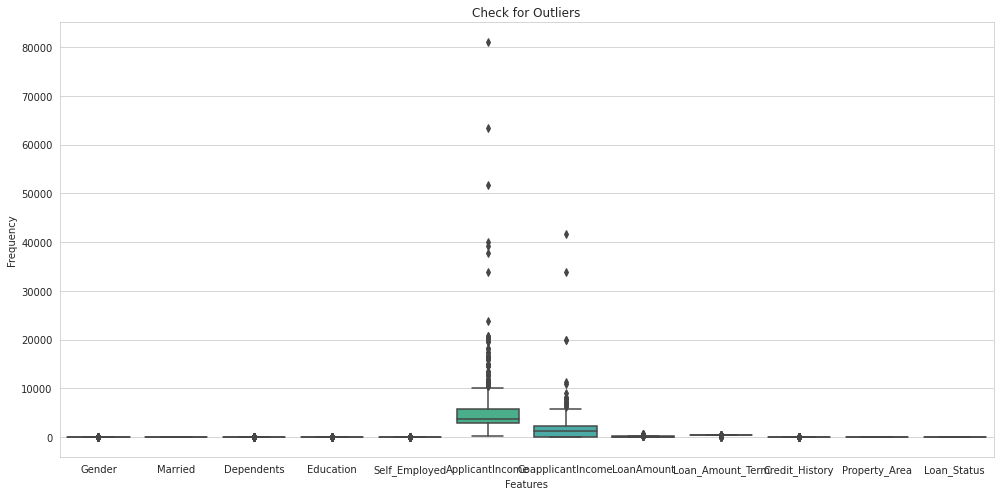

In [32]:
plt.figure(figsize=(14,7));
sns.boxplot(data=df);
plt.title('Check for Outliers');
plt.xlabel('Features');
plt.ylabel('Frequency');
plt.tight_layout()

In [33]:
def remove_outliers(data):
    q1 = np.quantile(data, 0.25)
    q3 = np.quantile(data, 0.75)
    iqr = q3 - q1
    ll, ul = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return ll, ul

In [34]:
for i in df.columns:
    ll, ul = remove_outliers(df[i])
    df[i] = np.where(df[i] < ll, ll, df[i])
    df[i] = np.where(df[i] > ul, ul, df[i]) 

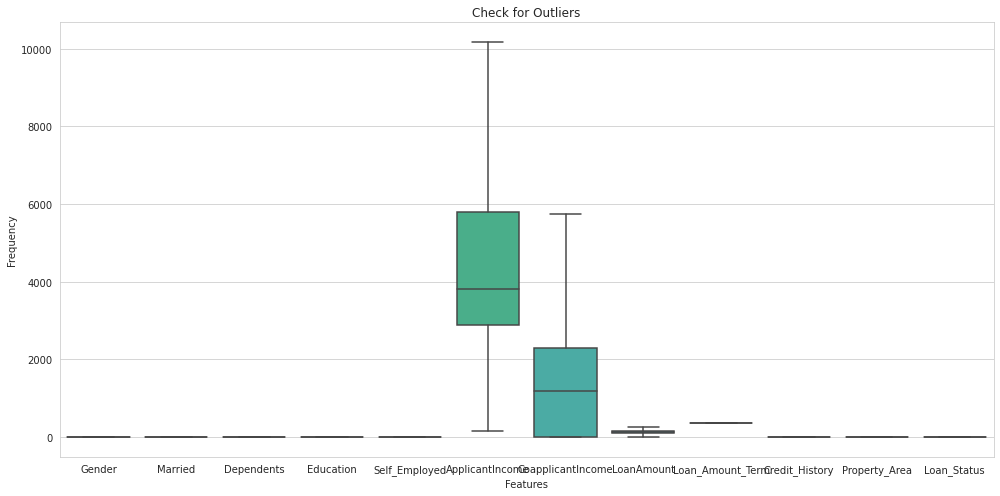

In [35]:
plt.figure(figsize=(14,7));
sns.boxplot(data=df);
plt.title('Check for Outliers');
plt.xlabel('Features');
plt.ylabel('Frequency');
plt.tight_layout()

#### Since, scaling of features impact from scaling or magnitude of Applicant and CoApplicant Income feature. Therefore, we have to perform scaling scaling so that every feature will be on same scale which in result help us to generate or predict accurate result.

### Performing Scaling 

In [36]:
scalar = StandardScaler()

In [37]:
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

In [38]:
temp = scalar.fit_transform(X)
df = pd.DataFrame(data=temp, columns=df.columns[:-1])

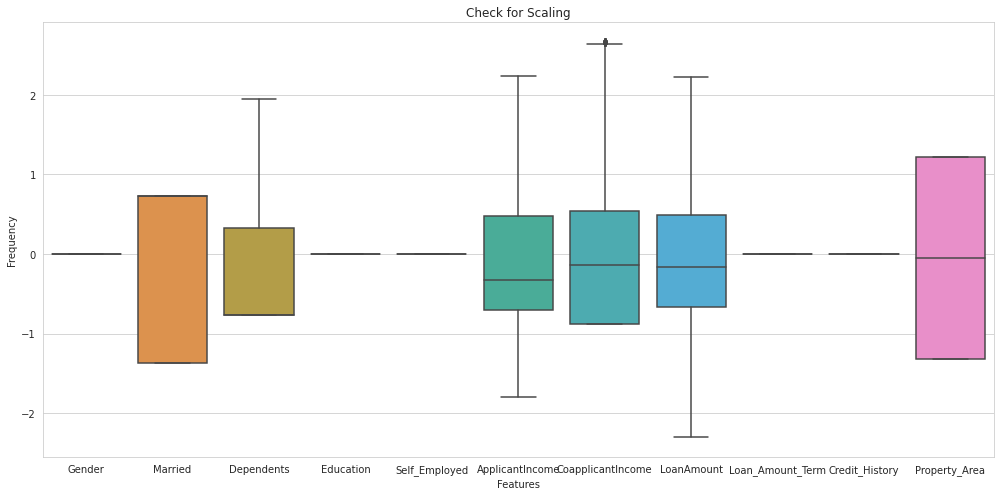

In [39]:
plt.figure(figsize=(14,7));
sns.boxplot(data=df);
plt.title('Check for Scaling');
plt.xlabel('Features');
plt.ylabel('Frequency');
plt.tight_layout()

#### All features are on the same scale, now we will start building our model.

### End of EDA

### Splitting into train and test split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

## Model Building

In [41]:
models  = [LogisticRegression, MLPClassifier, DecisionTreeClassifier, RandomForestClassifier, LDA]
for i in models:
    model = i().fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print("{} \n train_score: {} \n test_score: {}".format(i, train_score, test_score))
    print(" ----------------- ")

<class 'sklearn.linear_model._logistic.LogisticRegression'> 
 train_score: 0.6883910386965377 
 test_score: 0.6829268292682927
 ----------------- 
<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'> 
 train_score: 0.7026476578411406 
 test_score: 0.6016260162601627
 ----------------- 
<class 'sklearn.tree._classes.DecisionTreeClassifier'> 
 train_score: 0.9959266802443992 
 test_score: 0.5609756097560976
 ----------------- 
<class 'sklearn.ensemble._forest.RandomForestClassifier'> 
 train_score: 0.9959266802443992 
 test_score: 0.6422764227642277
 ----------------- 
<class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'> 
 train_score: 0.6883910386965377 
 test_score: 0.6829268292682927
 ----------------- 


#### Clearly we can see that Decision Tree and Random Forest are overfit on this dataset therefore we will go further with logistic regression, MLP and LDA models.

### Model Tuning

In [58]:
pipe = Pipeline([('classifier' , LogisticRegression())])

param_grid = [
    {
      'classifier' : [LogisticRegression()],
      'classifier__penalty' : ['l1', 'l2'],
      'classifier__C' : np.logspace(-4, 4, 20),
      'classifier__solver' : ['liblinear']
    },
    {
      'classifier' : [DecisionTreeClassifier()],
      'classifier__criterion' : ['gini', 'entropy'],
      'classifier__max_depth' : [5,10,20],        
      'classifier__min_samples_split' : [2, 6, 8],
      'classifier__min_samples_leaf' : [5, 10, 15]
    },
    {
      'classifier' : [RandomForestClassifier()],
      'classifier__n_estimators' : [100, 200, 400],
      'classifier__max_features' :[4, 8, 10],
      'classifier__criterion' : ['gini', 'entropy'],
      'classifier__max_depth' : [5,10,20],        
      'classifier__min_samples_split' : [2, 6, 8],
      'classifier__min_samples_leaf' : [5, 10, 15]
    },
    {
      'classifier' : [MLPClassifier()],
      'classifier__hidden_layer_sizes': [100, 200, 400],
      'classifier__activation': ['tanh', 'relu'],
      'classifier__solver': ['sgd', 'adam'],
      'classifier__alpha': [0.0001, 0.05],
      'classifier__learning_rate': ['constant','adaptive'],
      'classifier__tol': [0.001, 0.0001, 0.00001]
    },
    {
      'classifier' : [LDA()],
      'classifier__solver': ['svd', 'lsqr', 'eigen'],
      'classifier__shrinkage': np.arange(0, 1, 0.01)
    }
]

In [59]:
clf = GridSearchCV(pipe, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

In [60]:
best_clf = clf.fit(X_train, y_train)

Fitting 3 folds for each of 1024 candidates, totalling 3072 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 838 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1188 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1638 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 2188 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 3072 out of 3072 | elapsed:  6.9min finished


In [68]:
model = best_clf.best_estimator_

In [69]:
model.fit(X_train, y_train)

Pipeline(steps=[('classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=5,
                                        max_features=8, min_samples_leaf=5,
                                        n_estimators=200))])

In [83]:
train_predict = model.predict(X_train)
train_predict_proba = model.predict_proba(X_train)

In [84]:
test_predict = model.predict(X_test)
test_predict_proba = model.predict_proba(X_test)

In [72]:
print('Train Score: -', model.score(X_train, y_train))

Train Score: - 0.7169042769857433


In [73]:
print('Train Score: -', model.score(X_test, y_test))

Train Score: - 0.6747967479674797


In [74]:
print(classification_report(y_train, train_predict))

              precision    recall  f1-score   support

         0.0       1.00      0.09      0.17       153
         1.0       0.71      1.00      0.83       338

    accuracy                           0.72       491
   macro avg       0.85      0.55      0.50       491
weighted avg       0.80      0.72      0.62       491



In [75]:
print(classification_report(y_test, test_predict))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        39
         1.0       0.68      0.99      0.81        84

    accuracy                           0.67       123
   macro avg       0.34      0.49      0.40       123
weighted avg       0.46      0.67      0.55       123



#### Clearly, we can see that random forest classifier is having the best estimatior and score but after looking by the classficatio report, we can conclude that our model works well on training data but statistically not work well on test data.